# Score-based beat detection
Beat is specified by the phase and the period. Period is simply $60/\tau$ (where $\tau$ is the tempo). Phase specifies a time shift of the beat sinusoid from 0. 

In the score-based approach, we try all possible time shifts (or not all, but those that make sense in our case), calculate score for each one and then pick the one with the highest score. We start with 0-second time shift. Then we will start increasing the time shift by 1 millisecond until we reach the time shift of p seconds. We will calculate score for each of those time shifts and then pick the one with the highest score.

In [15]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from RhythmRecognition.onset import spectral
from RhythmRecognition.tempo import fourier
from RhythmRecognition.beat import score
from RhythmRecognition.beat.click_track import *
from RhythmRecognition.constants import *
import IPython.display as ipd

mpl.rcParams.update({'font.size': 16})

audiofile = "../audio_files/spark.wav"


## Compute novelty function
First step is to compute a novelty function of the audio signal.

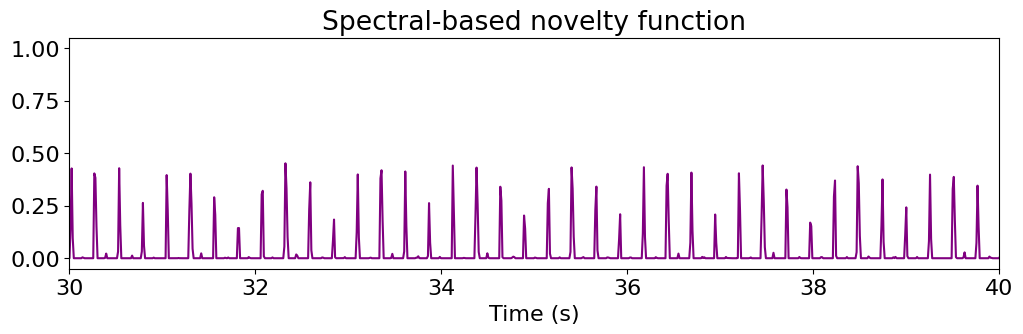

In [16]:
novelty_function = spectral.SpectralNovelty(audiofile)
novelty_function = novelty_function.get()

frames = np.arange(len(novelty_function))
t = librosa.frames_to_time(frames, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)

plt.figure(figsize=(12, 3))
plt.plot(t, novelty_function, 'purple')
plt.xlim(30, 40)
plt.xlabel("Time (s)")
plt.title("Spectral-based novelty function")
plt.show()

## Compute tempogram
Then, we need to compute a tempogram of the song. We will use the Fourier-based tempogram, since it gives the best results.

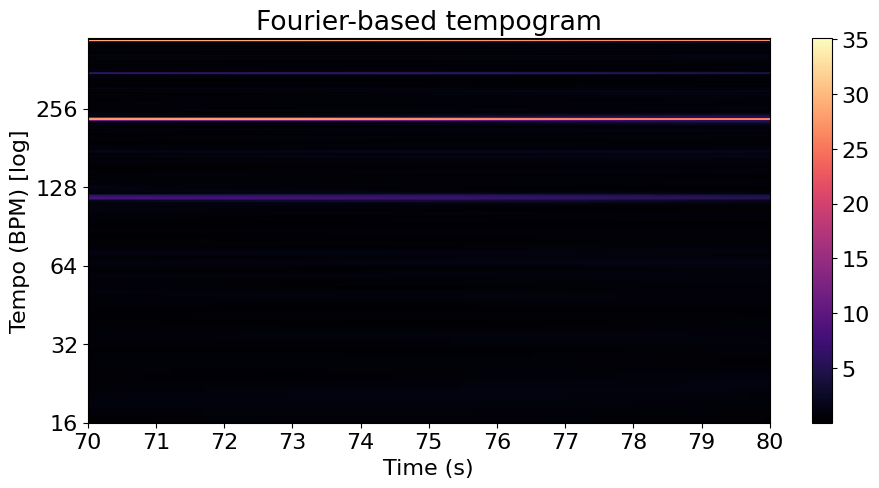

In [17]:
fourier_tempogram = fourier.FourierTempogram(novelty_function)
tempogram = fourier_tempogram.get_tempogram()

plt.figure(figsize=(11, 5))
librosa.display.specshow(tempogram, x_axis='time', y_axis='fourier_tempo', sr=SAMPLING_RATE, cmap='magma')
plt.xlabel("Time (s)")
plt.ylabel("Tempo (BPM) [log]")
plt.xlim(70, 80)
plt.colorbar()
plt.title("Fourier-based tempogram")
plt.show()

Then, we can extract the most dominant tempo from the tempogram (correct value is 117 BPM).

In [18]:
tempo = fourier_tempogram.get_tempo()
print(tempo)

117


## Beat detection
After computing the tempogram and obtaining the most dominant tempo, we can move to beat detection. 

### Beat time shift
We can compute the beat time shift. Correct time shift is 0 seconds, but small errors (difference around ~10 ms) are not detectable by human ears, so results with small errors are still classified as correct.

In [19]:
beat_tracker = score.ScoreBeatTracker(novelty_function, tempo=tempo)
shift = beat_tracker.get_time_shift()
print("Time shift:", shift, "seconds.")

Time shift: 0.012 seconds.


### Generate beat track over audio
We can generate a beat track over our song and listen to it to check if the found time shift is correct.

In [20]:
beat_track = beat_tracker.get_beat_track()  # get beat track

# load part of the audio signal
# unfortunately, ipd.Audio cannot generate the whole song with beat track over it, so we need to load a shorter part
signal, sr = librosa.load(audiofile, duration=30, sr=SAMPLING_RATE)

# create click track from beat times
click_track = librosa.clicks(times=beat_track, sr=SAMPLING_RATE, length=len(signal), hop_length=HOP_LENGTH)
ipd.Audio(signal + click_track, rate=SAMPLING_RATE)

### Plot beat times over novelty function
We can also create a plot with beat times drawn over the novelty function.

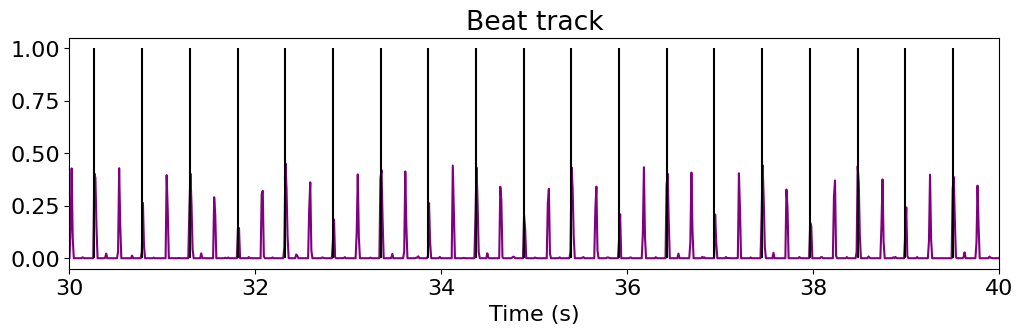

In [21]:
plt.figure(figsize=(12, 3))
plt.plot(t, novelty_function, 'purple')
plt.vlines(beat_track, 0, novelty_function.max(), color='black')
plt.xlim(30, 40)
plt.xlabel("Time (s)")
plt.title("Beat track")
plt.show()